#### 폐암 사망 데이터 분석
- 사용 데이터 : lung_cancer_mortality_data_large_v2.csv
- 피처/속성 : 17개
- 타겟/라벨 : survived
- 학습-방법 : 지도학습 > 분류> 이진분류
- 학습 알고리즘 : 인공신경망(ANN) -> 심층 신경망 (MLP, DNN) : 은닉층이 많은 구성
- 프레임워크 : Pytorch

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

#### 1. 데이터 불러오기

In [2]:
data = './lung_cancer_mortality_data_large_v2.csv'
lungDF = pd.read_csv(data)
lungDF.head()

,id,age,gender,country,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Female,Germany,2016-04-07,Stage III,2016-04-21,No,Never Smoked,31.1,257,1,1,0,0,Combined,2017-11-15,0
1,2,50.0,Male,Czech Republic,2023-04-22,Stage III,2023-05-02,Yes,Passive Smoker,25.9,208,1,0,0,0,Radiation,2024-04-25,0
2,3,65.0,Male,Romania,2023-04-07,Stage IV,2023-04-12,No,Never Smoked,18.9,193,0,0,0,0,Surgery,2025-03-11,0
3,4,51.0,Female,Latvia,2016-02-07,Stage III,2016-02-13,Yes,Former Smoker,34.6,249,1,1,1,0,Surgery,2017-04-14,1
4,5,37.0,Male,Greece,2023-12-01,Stage I,2023-12-03,Yes,Never Smoked,40.2,262,0,0,0,0,Chemotherapy,2024-09-20,0


#### 2. 데이터 분포 확인

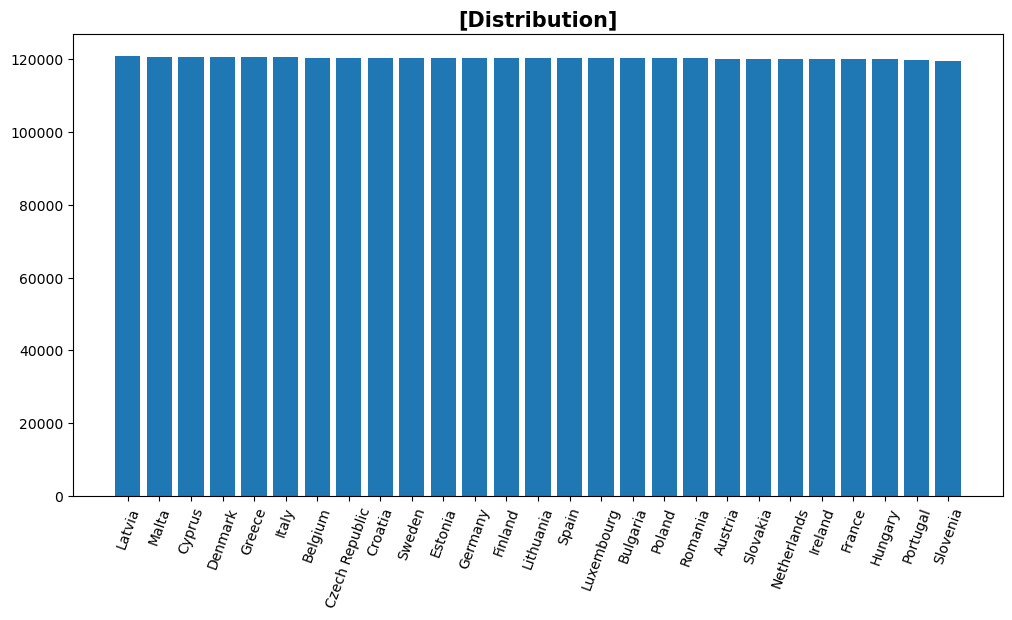

In [3]:
country = lungDF['country'].value_counts()

plt.figure(figsize=(12,6))
plt.bar(country.index, country.values)
plt.xticks(rotation=70)
plt.title('[Distribution]', fontsize = 15, fontweight = 'bold')
plt.show()

In [4]:
dead = lungDF.groupby('survived').get_group(0)

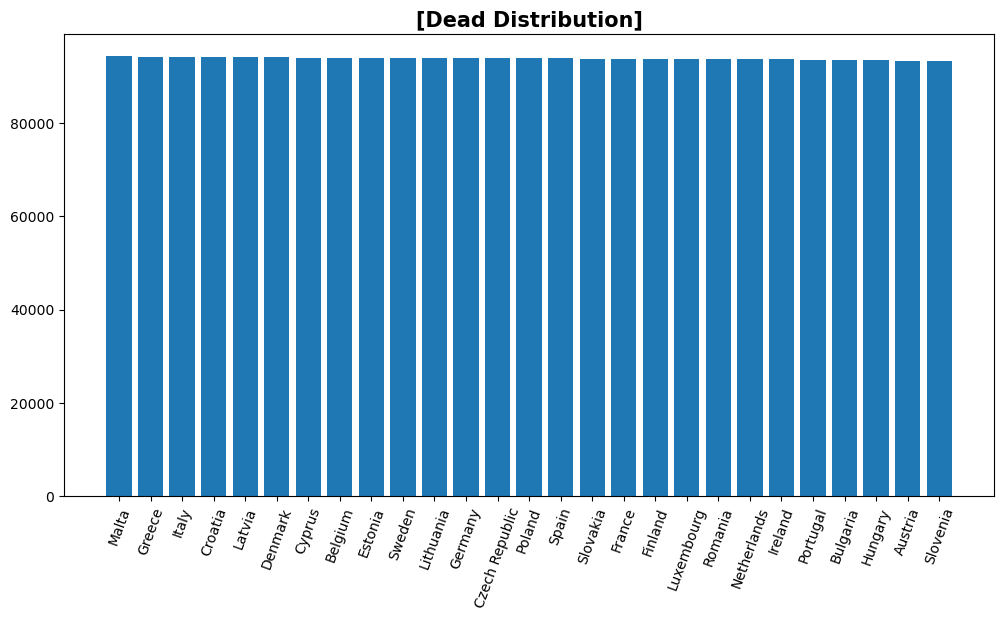

In [5]:
country = dead['country'].value_counts()

plt.figure(figsize=(12,6))
plt.bar(country.index, country.values)
plt.xticks(rotation=70)
plt.title('[Dead Distribution]', fontsize = 15, fontweight = 'bold')
plt.show()

In [6]:
alive = lungDF.groupby('survived').get_group(1)

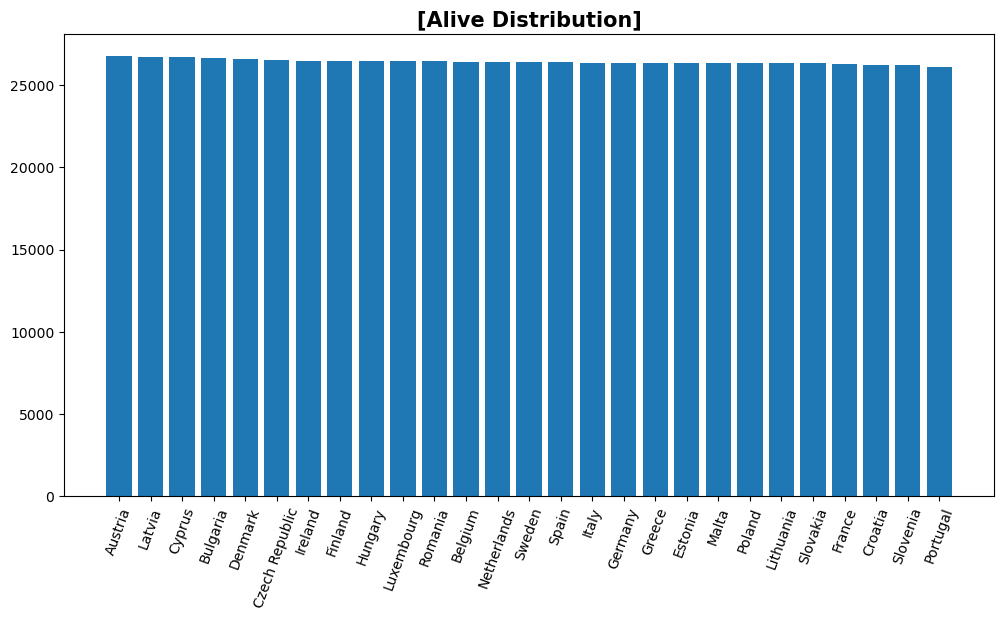

In [7]:
country = alive['country'].value_counts()

plt.figure(figsize=(12,6))
plt.bar(country.index, country.values)
plt.xticks(rotation=70)
plt.title('[Alive Distribution]', fontsize = 15, fontweight = 'bold')
plt.show()

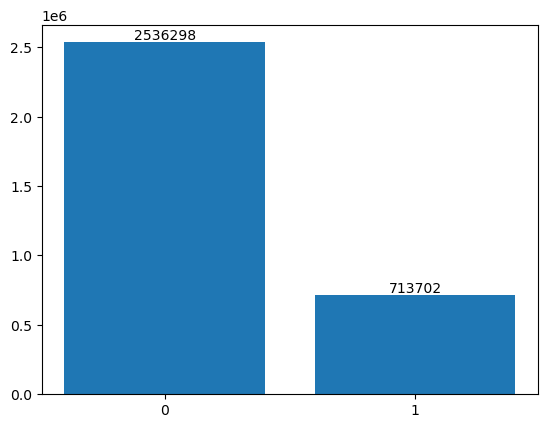

In [8]:
life = lungDF['survived'].value_counts()
bar = plt.bar(life.index, life.values)
plt.xticks([0,1])
plt.bar_label(bar, life.values)
plt.show()

#### 3. 데이터 전처리

In [9]:
lungDF = lungDF.drop(['id','country'], axis=1)

In [10]:
lungDF['age'] = lungDF['age'].astype('int')
lungDF['beginning_of_treatment_date'] = pd.to_datetime(lungDF['beginning_of_treatment_date'])
lungDF['end_treatment_date'] = pd.to_datetime(lungDF['end_treatment_date'])
lungDF['diagnosis_date'] = pd.to_datetime(lungDF['diagnosis_date'])

In [11]:
lungDF['cancer_stage'] = lungDF['cancer_stage'].replace({'Stage I':1,'Stage II':2, 'Stage III':3, 'Stage IV':4})
lungDF['gender'] = lungDF['gender'].replace({'Male':0, 'Female':1})
lungDF['family_history'] = lungDF['family_history'].replace({'No':0, 'Yes':1})
lungDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250000 entries, 0 to 3249999
Data columns (total 16 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   age                          int32         
 1   gender                       int64         
 2   diagnosis_date               datetime64[ns]
 3   cancer_stage                 int64         
 4   beginning_of_treatment_date  datetime64[ns]
 5   family_history               int64         
 6   smoking_status               object        
 7   bmi                          float64       
 8   cholesterol_level            int64         
 9   hypertension                 int64         
 10  asthma                       int64         
 11  cirrhosis                    int64         
 12  other_cancer                 int64         
 13  treatment_type               object        
 14  end_treatment_date           datetime64[ns]
 15  survived                     int64         
dtype

In [12]:
lungDF['smoking_status'].value_counts()

smoking_status
Passive Smoker    814289
Former Smoker     812264
Current Smoker    811824
Never Smoked      811623
Name: count, dtype: int64

In [13]:
lungDF['treatment_type'].value_counts()

treatment_type
Surgery         813480
Chemotherapy    812702
Radiation       812263
Combined        811555
Name: count, dtype: int64

In [14]:
endcoder = LabelEncoder()

In [15]:
lungDF['smoking_status'] = lungDF['smoking_status'].replace({'Never Smoked':0,'Passive Smoker':1,'Former Smoker':2,'Current Smoker':3})

In [16]:
endcoder.fit(lungDF['treatment_type'])
lungDF['treatment_type'] = endcoder.transform(lungDF['treatment_type'])

In [17]:
lungDF['start_days'] = (lungDF['beginning_of_treatment_date']-lungDF['diagnosis_date']).dt.days
lungDF['treatment_days'] = (lungDF['end_treatment_date'] - lungDF['beginning_of_treatment_date']).dt.days
lungDF.head()

,age,gender,diagnosis_date,cancer_stage,beginning_of_treatment_date,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived,start_days,treatment_days
0,64,1,2016-04-07,3,2016-04-21,0,0,31.1,257,1,1,0,0,1,2017-11-15,0,14,573
1,50,0,2023-04-22,3,2023-05-02,1,1,25.9,208,1,0,0,0,2,2024-04-25,0,10,359
2,65,0,2023-04-07,4,2023-04-12,0,0,18.9,193,0,0,0,0,3,2025-03-11,0,5,699
3,51,1,2016-02-07,3,2016-02-13,1,2,34.6,249,1,1,1,0,3,2017-04-14,1,6,426
4,37,0,2023-12-01,1,2023-12-03,1,0,40.2,262,0,0,0,0,0,2024-09-20,0,2,292


In [18]:
cancerDF = lungDF.drop(['diagnosis_date','beginning_of_treatment_date','end_treatment_date'], axis=1)
cancerDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250000 entries, 0 to 3249999
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   age                int32  
 1   gender             int64  
 2   cancer_stage       int64  
 3   family_history     int64  
 4   smoking_status     int64  
 5   bmi                float64
 6   cholesterol_level  int64  
 7   hypertension       int64  
 8   asthma             int64  
 9   cirrhosis          int64  
 10  other_cancer       int64  
 11  treatment_type     int32  
 12  survived           int64  
 13  start_days         int64  
 14  treatment_days     int64  
dtypes: float64(1), int32(2), int64(12)
memory usage: 347.1 MB


In [19]:
featureDF = cancerDF.drop('survived',axis=1)
targetDF = cancerDF['survived']

In [20]:
# 학습용/테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state = 10)

In [21]:
rf_model = RandomForestClassifier(random_state=10, oob_score=True, n_estimators=200)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=10)

In [23]:
params = {'max_depth':[2,5,7,10], 'min_samples_leaf' : [1,3,5,7,9], 'max_features':['sqrt','log2', None]}

In [24]:
rf_cv = RandomizedSearchCV(rf_model, param_distributions=params, refit=True, verbose=3)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=5, max_features=log2, min_samples_leaf=3;, score=0.780 total time= 4.0min
[CV 2/5] END max_depth=5, max_features=log2, min_samples_leaf=3;, score=0.780 total time= 4.1min
[CV 3/5] END max_depth=5, max_features=log2, min_samples_leaf=3;, score=0.780 total time= 4.5min
[CV 4/5] END max_depth=5, max_features=log2, min_samples_leaf=3;, score=0.780 total time= 4.8min
[CV 5/5] END max_depth=5, max_features=log2, min_samples_leaf=3;, score=0.780 total time= 4.2min
[CV 1/5] END max_depth=5, max_features=None, min_samples_leaf=5;, score=0.780 total time=12.3min


KeyboardInterrupt: 

In [ ]:
best = rf_cv.best_estimator_
best.fit(X_train, y_train)

In [ ]:
feature = best.feature_importances_
feature

In [ ]:
colors = ['#FF7F50', '#FFB400', '#FF895A','#FFBE0A', '#FF9364', '#FFC314', '#FF9D6E', '#FFC81E', '#FFA778', '#FFB182', '#FFBB8C', '#FFC091', '#FFC596', '#FFCA9B']
colors.reverse()
plt.figure(figsize=(12,5))
result = plt.barh(featureDF.columns.to_list(), feature, color = colors, edgecolor = 'k')
plt.bar_label(result, np.round(feature,3),padding=3)
plt.title('Feature Importances', fontsize = 18, fontweight='bold')
plt.show()